In [1]:
# load data
df1 <- read.csv("flow_20130225-20130303.csv", skip = 1)
df2 <- read.csv("flow_20130304-20130310.csv", skip = 1)
df3 <- read.csv("flow_20130311-20130317.csv", skip = 1)
df4 <- read.csv("flow_20130318-20130324.csv", skip = 1)

In [2]:
df <- rbind(df1, df2, df3, df4)
df <- df[which((df$region_from == 1) & (df$region_to == 5)), c("date", "time_id", "v0_num_traj")]
table(df$time_id)


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
12  8  8  8  8 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 

Note: we can see that we only have all record for time_id from 6 to 24 every day, so we should choose this period as "busy period" for analyzing.

In [3]:
df <- df[which(df$time_id %in% c(6:24)), ]
summary(df)

         date        time_id    v0_num_traj    
 2013-02-25: 19   Min.   : 6   Min.   :  1.00  
 2013-02-26: 19   1st Qu.:10   1st Qu.: 46.00  
 2013-02-27: 19   Median :15   Median : 71.00  
 2013-02-28: 19   Mean   :15   Mean   : 85.84  
 2013-03-01: 19   3rd Qu.:20   3rd Qu.:105.00  
 2013-03-02: 19   Max.   :24   Max.   :307.00  
 (Other)   :418                                

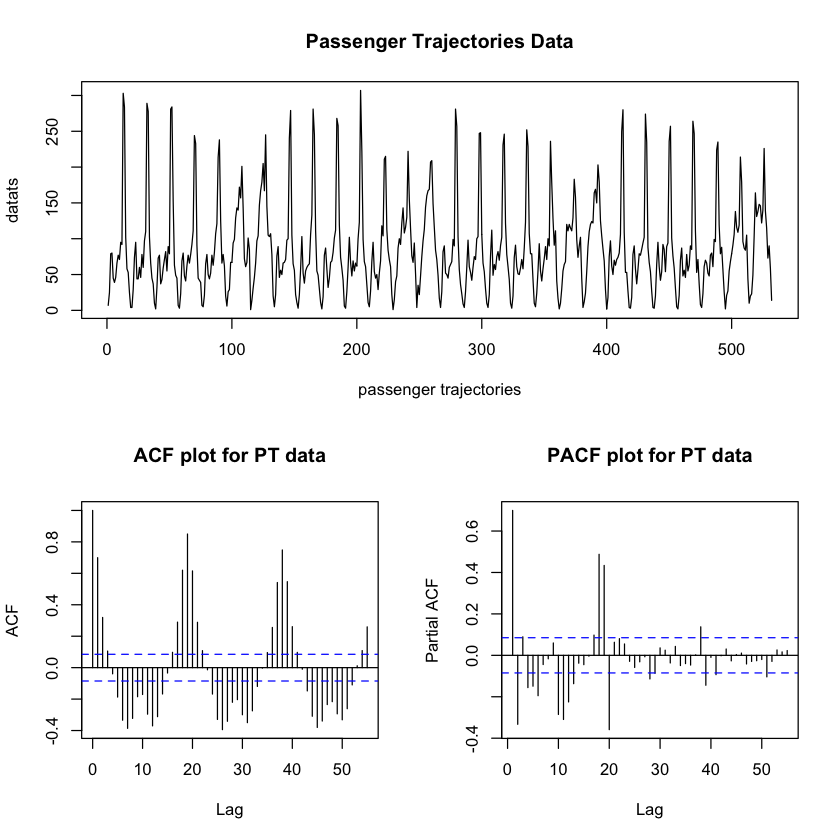

In [4]:
datats <- ts(df$v0_num_traj)

layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE))
plot.ts(datats, main = "Passenger Trajectories Data", xlab = "passenger trajectories")
acf(datats, main = "ACF plot for PT data", lag.max = 55)
pacf(datats, main = "PACF plot for PT data", lag.max = 55)

From the time series plot, we can see that the time series data is possibly seasonal, oscillating between about 0 and 300. The ACF plot shows that the ACF value is highly periodic with the same period as the time series data, and decays very slowly. Althougt it is not as clear as the ACF, the PACF is also periodic but decays quickly.  

### Daily Seasonal Trend (frequency = 19(hours))

In [5]:
T.daily <- ts(df$v0_num_traj, frequency = 19)

In [6]:
head(weekdays(as.Date(df$date)))

[1] "Monday" "Monday" "Monday" "Monday" "Monday" "Monday"

The data starts with Monday, which means that every 7 days belong to one week.

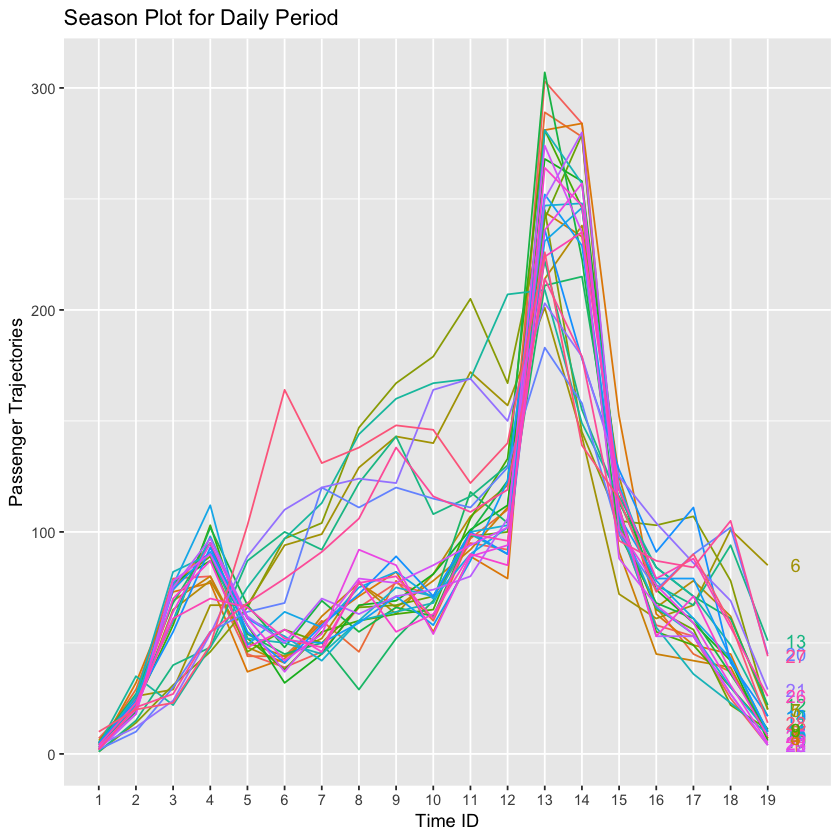

In [7]:
library(forecast)

ggseasonplot(T.daily, xlab = "Time ID", ylab = "Passenger Trajectories", 
             main = "Season Plot for Daily Period", year.labels = TRUE)

We can see that the data for most of days have similar trends. Those days that are not matched with other days might be weekend.  
  
Let's try plot the seasonal data without weekend.

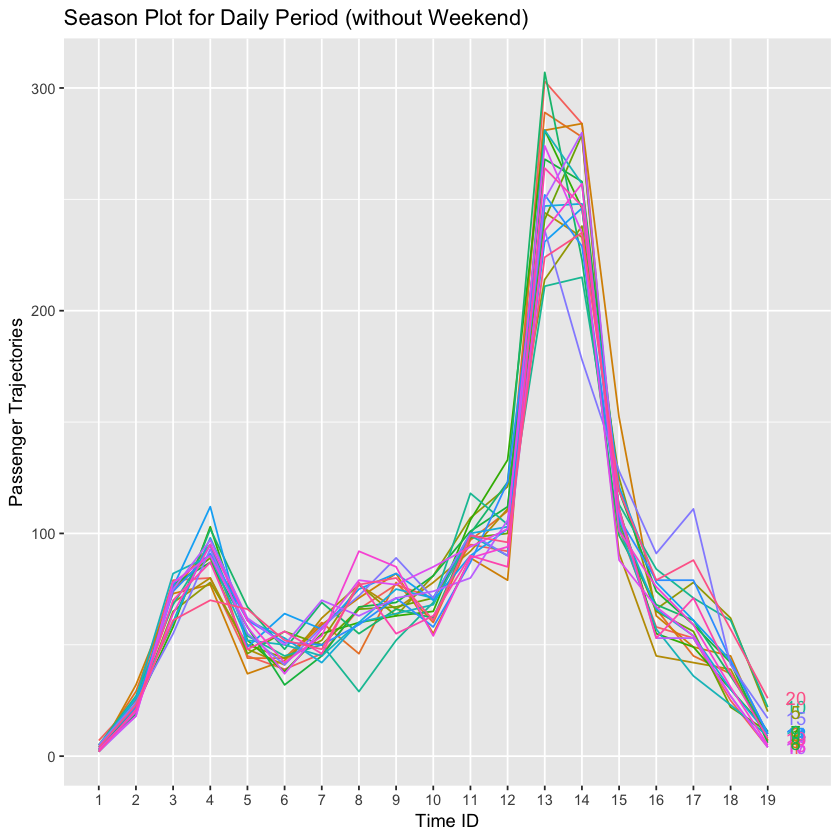

In [8]:
T.weekday <- ts(df[-which(weekdays(as.Date(df$date))%in%c("Saturday", "Sunday")), ]$v0_num_traj, frequency = 19)

ggseasonplot(T.weekday, xlab = "Time ID", ylab = "Passenger Trajectories", 
             main = "Season Plot for Daily Period (without Weekend)", year.labels = TRUE)

It looks better, indicates that the weekday data have highly seasonal trend.  
  
We can also have a look at the decompose plot.

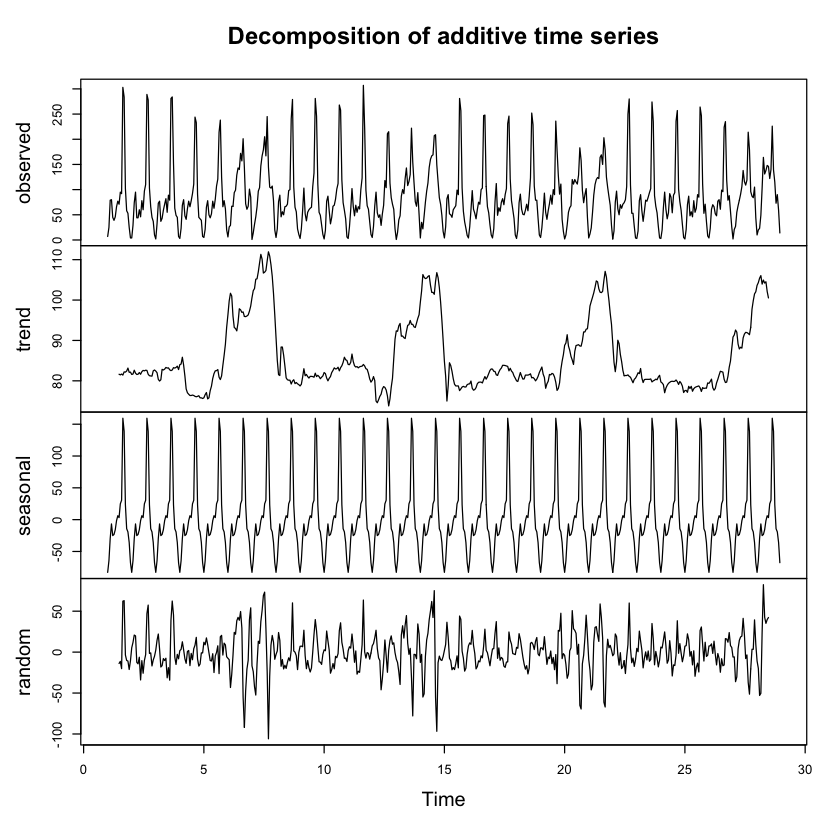

In [9]:
plot(decompose(T.daily))

The seasonal component indicates that the data indeed have a seasonal trend.  
  
Finally, in order to check seasonality in a formal way, let's try ljung-box test.

In [10]:
Box.test(T.daily, lag = min(2*19, length(T.daily)/5), type = "Ljung")


	Box-Ljung test

data:  T.daily
X-squared = 2676.6, df = 38, p-value < 2.2e-16


The p-value is extremely small, indicates that the time series is seasonal.

### Weekly Seasonal Trend (frequency = 19(hours)*7(days))

In [11]:
T.weekly <- ts(df$v0_num_traj, frequency = 19*7)

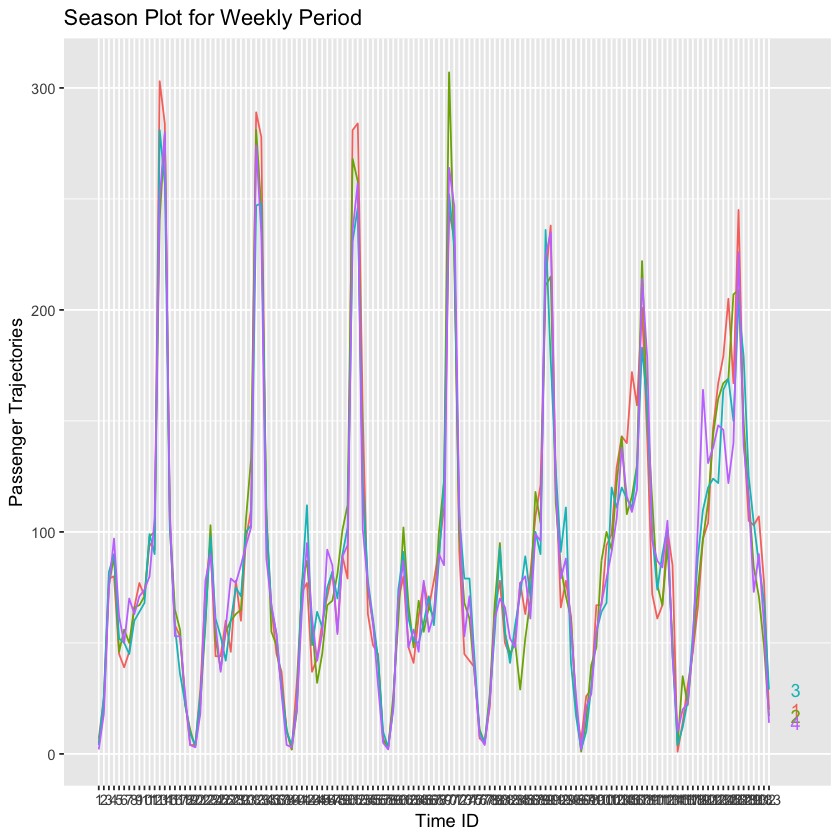

In [12]:
ggseasonplot(T.weekly, xlab = "Time ID", ylab = "Passenger Trajectories", 
             main = "Season Plot for Weekly Period", year.labels = TRUE)

We can see that the data for week period has significant seasonal trends.  

We can also have a look at the decompose plot.

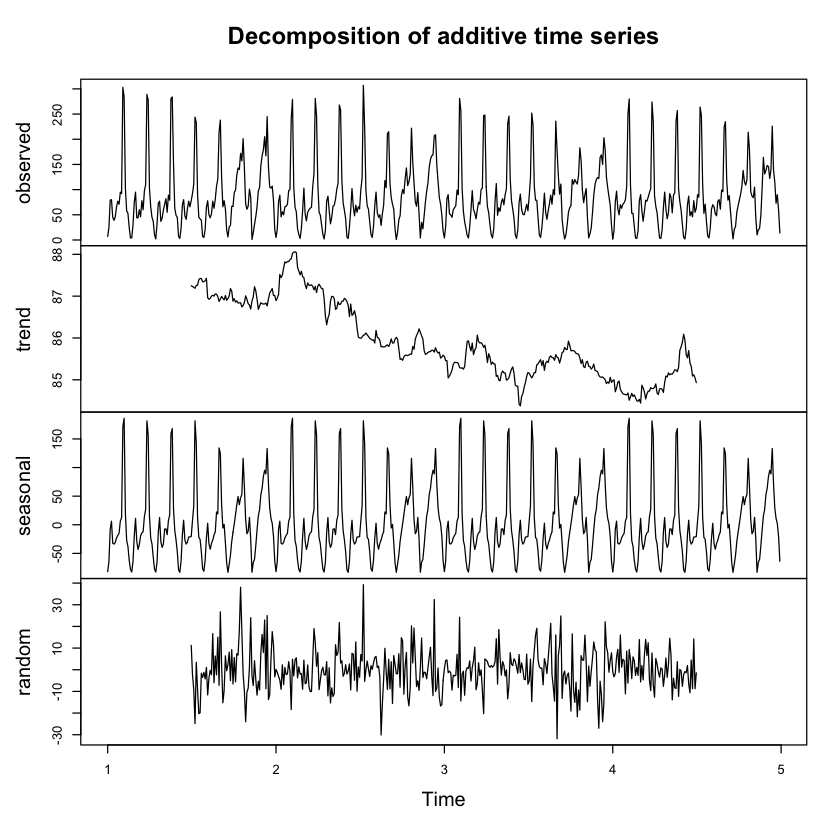

In [13]:
plot(decompose(T.weekly))

The third plot, seasonal plot, indicates that the weekly period data also have a seasonal trend.  
  
Let's use box-ljung test as well.

In [14]:
Box.test(T.weekly, lag = min(2*19*7, length(T.weekly)/5), type = "Ljung")


	Box-Ljung test

data:  T.weekly
X-squared = 6419.7, df = 106.4, p-value < 2.2e-16


The p-value is extremely small, indicates that the time series is indeed seasonal.

To sum up, both daily period and weekly period have seasonal trend but not stationary, the weekly period shows better seasonal trend, since weekday data and weekend data perform different in daily period.

# Non-stochastic Model (Seasonal Naïve Model)

Seasonal naïve method predicts the last observed value of the same season. Since our time series data is highly seasonal, so we will choose this method to fit the non-stochastic model.

In [15]:
snaive.fit <- snaive(T.weekly)

In [16]:
summary(snaive.fit)


Forecast method: Seasonal naive method

Model Information:
Call: snaive(y = T.weekly) 

Residual sd: 16.5984 

Error measures:
                     ME     RMSE      MAE       MPE     MAPE MASE       ACF1
Training set -0.7719298 16.59831 11.76942 -5.006884 19.70424    1 0.05050471

Forecasts:
         Point Forecast       Lo 80     Hi 80         Lo 95     Hi 95
5.000000              2 -19.2717422  23.27174 -30.532322265  34.53232
5.007519             18  -3.2717422  39.27174 -14.532322265  50.53232
5.015038             75  53.7282578  96.27174  42.467677735 107.53232
5.022556             97  75.7282578 118.27174  64.467677735 129.53232
5.030075             62  40.7282578  83.27174  29.467677735  94.53232
5.037594             50  28.7282578  71.27174  17.467677735  82.53232
5.045113             70  48.7282578  91.27174  37.467677735 102.53232
5.052632             63  41.7282578  84.27174  30.467677735  95.53232
5.060150             71  49.7282578  92.27174  38.467677735 103.53232
5.0676

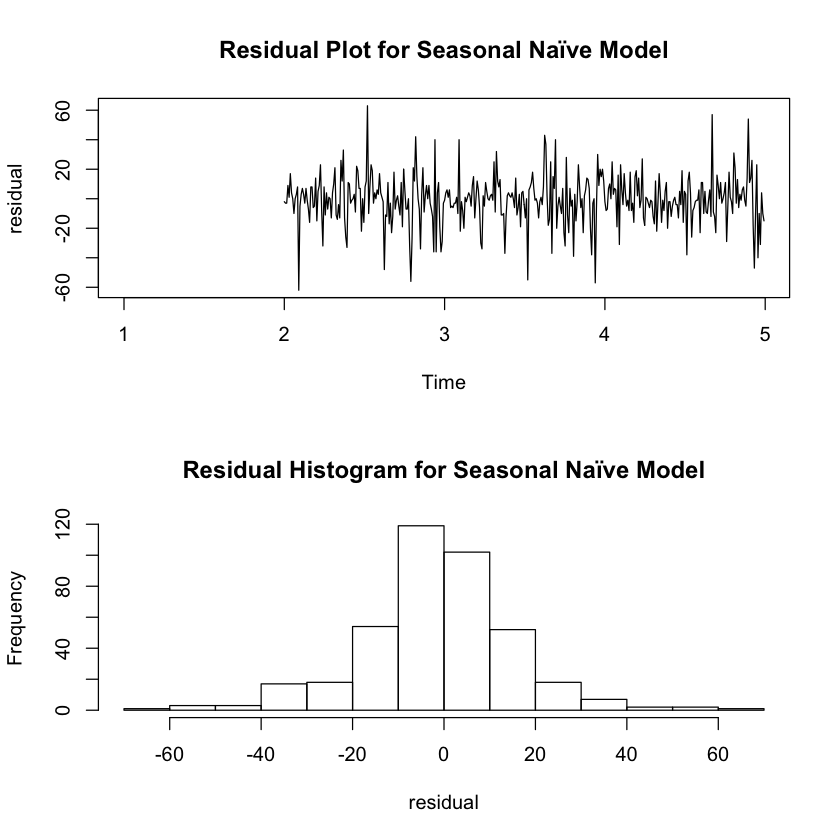

In [17]:
snaive.red <- snaive.fit$residuals

layout(matrix(c(1, 2), 2, 1, byrow = TRUE))
plot(snaive.red, main = "Residual Plot for Seasonal Naïve Model", ylab = "residual")
hist(snaive.red, main = "Residual Histogram for Seasonal Naïve Model", xlab = "residual")

# Stochastic Time Series Model

### Daily Seasonal Trend (frequency = 19(hours))

#### weekday model

In [18]:
weekday.fit1 <- auto.arima(T.weekday)
summary(weekday.fit1)

Series: T.weekday 
ARIMA(1,0,0)(1,1,0)[19] with drift 

Coefficients:
         ar1     sar1    drift
      0.2096  -0.5179  -0.0022
s.e.  0.0515   0.0442   0.0350

sigma^2 estimated as 223.4:  log likelihood=-1490
AIC=2988.01   AICc=2988.12   BIC=3003.56

Training set error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.02140152 14.50611 9.974551 -3.395488 18.18998 0.8080819
                   ACF1
Training set 0.01468902


In [19]:
# log-scale usually helps seasonal data fit a better ARIMA model, so try this one as well
weekday.fit2 <- auto.arima(log(T.weekday))
summary(weekday.fit2)

Series: log(T.weekday) 
ARIMA(2,0,2)(2,1,0)[19] with drift 

Coefficients:
         ar1      ar2      ma1     ma2     sar1     sar2  drift
      0.9950  -0.5386  -0.7419  0.5031  -0.5026  -0.3195  2e-04
s.e.  0.2254   0.1811   0.2284  0.1533   0.0558   0.0556  5e-04

sigma^2 estimated as 0.05839:  log likelihood=0.38
AIC=15.24   AICc=15.64   BIC=46.35

Training set error measures:
                      ME      RMSE       MAE        MPE     MAPE      MASE
Training set 0.001024626 0.2332345 0.1624526 -0.9919805 5.796914 0.8232252
                     ACF1
Training set -0.002005863


Compared the RMSE values, we can see that performing a log transformation helps. With a lower RMSE value, we prefer weekday.fit2 (with log).  
  
Now let's fit the ARIMA model for weekend data.

#### weekend model

In [20]:
T.weekend <- ts(df[which(weekdays(as.Date(df$date))%in%c("Saturday", "Sunday")), ]$v0_num_traj, frequency = 19)

weekend.fit1 <- auto.arima(T.weekend)
summary(weekend.fit1)

Series: T.weekend 
ARIMA(0,0,1)(2,1,0)[19] 

Coefficients:
         ma1     sar1     sar2
      0.2683  -0.7300  -0.0054
s.e.  0.0862   0.0989   0.1067

sigma^2 estimated as 344.5:  log likelihood=-582.85
AIC=1173.7   AICc=1174.02   BIC=1185.26

Training set error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.4863184 17.16478 12.26069 -3.436117 23.79232 0.5430141
                   ACF1
Training set 0.01648904


In [21]:
# also try log transformation for this model
weekend.fit2 <- auto.arima(log(T.weekend))
summary(weekend.fit2)

Series: log(T.weekend) 
ARIMA(1,0,0)(2,1,1)[19] 

Coefficients:
         ar1     sar1     sar2     sma1
      0.2508  -0.4376  -0.0046  -0.5859
s.e.  0.1002   0.2130   0.1780   0.2022

sigma^2 estimated as 0.09229:  log likelihood=-38.61
AIC=87.22   AICc=87.69   BIC=101.67

Training set error measures:
                      ME      RMSE       MAE  MPE MAPE     MASE      ACF1
Training set -0.01779792 0.2798619 0.1711995 -Inf  Inf 0.543161 0.1093437


Similar with the weekday model, we prefer weekend.fit2 (with log).

### Weekly Seasonal Trend (frequency = 19(hours)*7(days))

In [22]:
weekly.fit1 <- auto.arima(T.weekly)
summary(weekly.fit1)

Series: T.weekly 
ARIMA(0,0,0)(0,1,0)[133] 

sigma^2 estimated as 275.5:  log likelihood=-1687.07
AIC=3376.13   AICc=3376.14   BIC=3380.12

Training set error measures:
                     ME     RMSE     MAE       MPE     MAPE      MASE
Training set -0.5571353 14.37466 8.84888 -3.730163 14.80318 0.7518533
                   ACF1
Training set 0.05110408


In [23]:
weekly.fit2 <- auto.arima(log(T.weekly))
summary(weekly.fit2)

Series: log(T.weekly) 
ARIMA(1,0,1)(0,1,0)[133] 

Coefficients:
          ar1     ma1
      -0.7060  0.8257
s.e.   0.1325  0.1058

sigma^2 estimated as 0.07428:  log likelihood=-46.51
AIC=99.02   AICc=99.08   BIC=110.99

Training set error measures:
                       ME      RMSE       MAE  MPE MAPE      MASE       ACF1
Training set -0.004475314 0.2354442 0.1385426 -Inf  Inf 0.7527514 0.01237908


Also, weekly.fit2 is better.

# Q7. Model Predictions

## Non-stochastic Model

In [24]:
library(ggplot2)

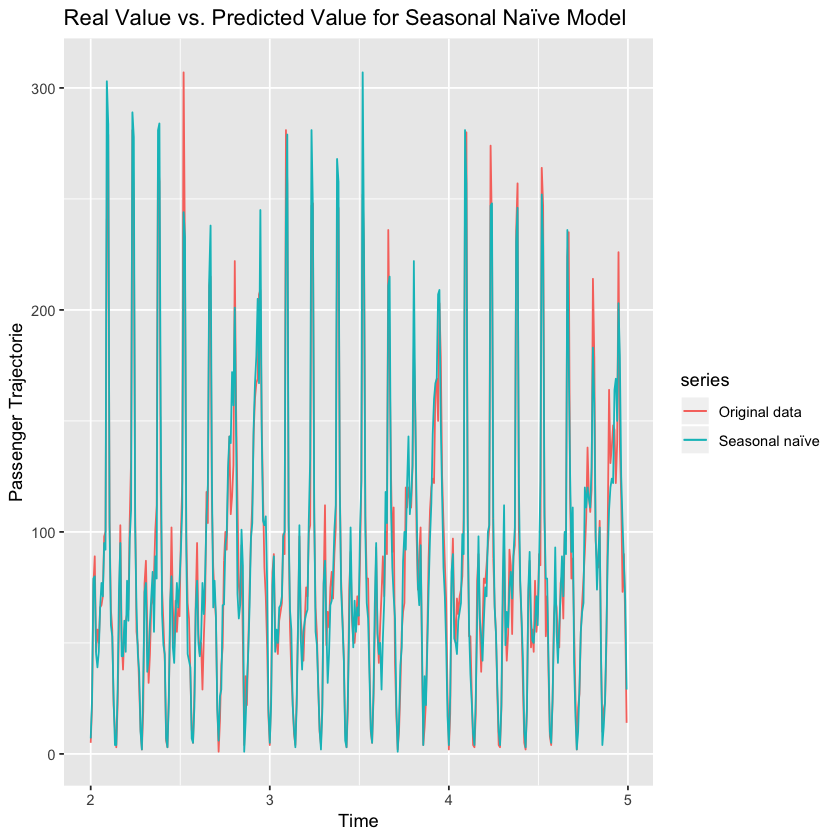

In [25]:
autoplot(window(T.weekly, start = c(2, 1)), series = "Original data", ylab = "Passenger Trajectorie", 
         main = "Real Value vs. Predicted Value for Seasonal Naïve Model") + 
    autolayer(window(fitted.values(snaive.fit), c(2, 1)), series = "Seasonal naïve") 

## Stochastic Time Series Model

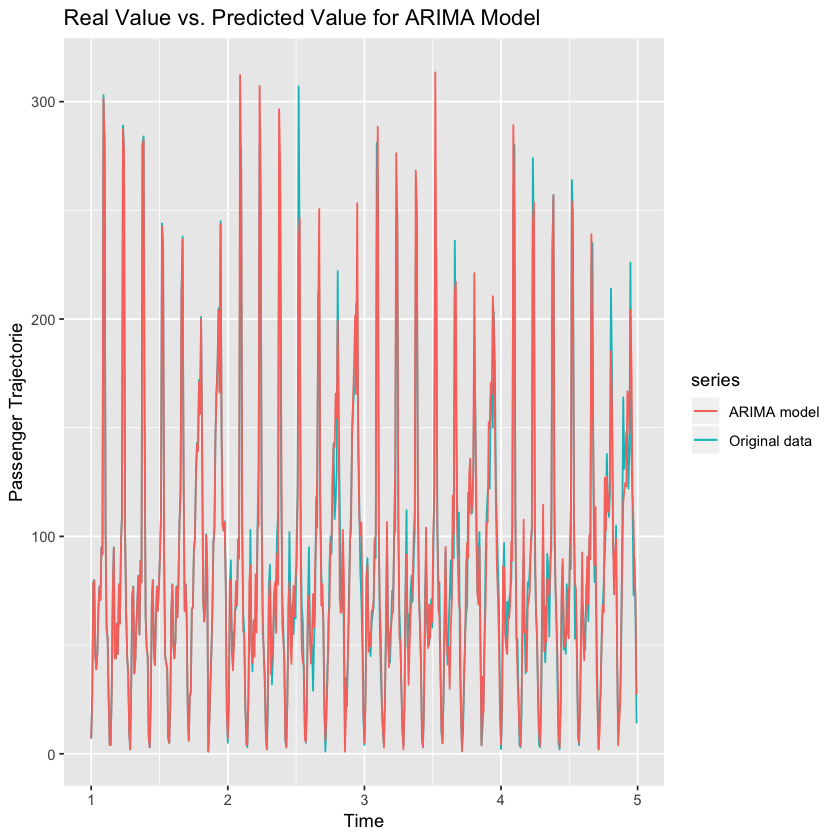

In [26]:
autoplot(T.weekly, series = "Original data", ylab = "Passenger Trajectorie", 
         main = "Real Value vs. Predicted Value for ARIMA Model") + 
    autolayer(exp(fitted(weekly.fit2)), series = "ARIMA model")

In [27]:
arima.red <- resid(weekly.fit2)

lower = exp(fitted(weekly.fit2) - 1.96 * sd(arima.red))
upper = exp(fitted(weekly.fit2) + 1.96 * sd(arima.red))

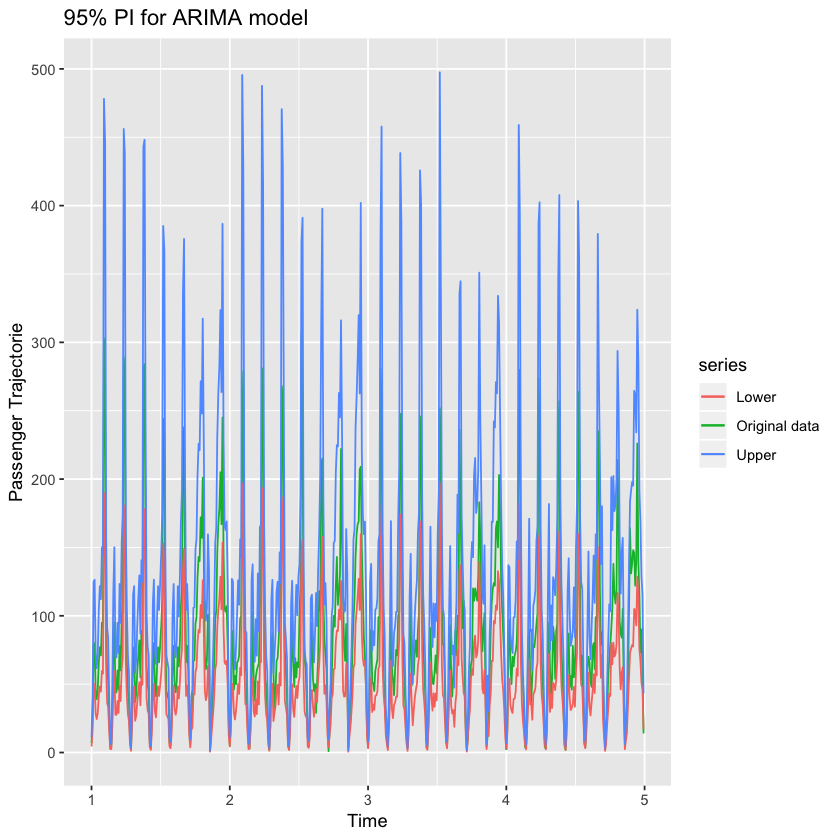

In [28]:
autoplot(T.weekly, series = "Original data", ylab = "Passenger Trajectorie", 
         main = "95% PI for ARIMA model") + 
    autolayer(lower, series = "Lower") + 
    autolayer(upper, series = "Upper")

# Q8. Evaluate accuracy 1 and 2 hours ahead

## Non-stochastic Model (Seasonal Naïve Model)

## 1 hour ahead

In [29]:
snaive_1h <- data.frame('estimated.value' = numeric(19), 
                             'real.value' = numeric(19))

for (t in 1:19){
    train_data <- window(T.weekly, end = c(4, 6*19 + t-1))
    test_data <- T.weekly[4*7*19 + t-19]

    evaluate.fit <- snaive(train_data, h = 1)
    snaive_1h[t, ] <- c(data.frame(evaluate.fit)$Point.Forecast, test_data)
}

sn_MSE_1 <- sum((snaive_1h$real.value - snaive_1h$estimated.value)^2)/19
sn_MSE_1 # seasonal naive model, 1 hour ahead

[1] 547.1053

## 2 hours ahead

In [30]:
snaive_2h <- data.frame('estimated.value' = numeric(19), 
                             'real.value' = numeric(19))

for (t in 1:19){
    train_data <- window(T.weekly, end = c(4, 6*19 + t-2))
    test_data <- T.weekly[4*7*19 + t-19]
    
    evaluate.fit <- snaive(train_data, h = 2)
    snaive_2h[t, ] <- c(data.frame(evaluate.fit)$Point.Forecast[2], test_data)
}

sn_MSE_2 <- sum((snaive_2h$real.value - snaive_2h$estimated.value)^2)/19
sn_MSE_2 # seasonal naive model, 2 hours ahead

[1] 547.1053

## ARIMA model

## 1 hour ahead

#### frequency = 19 (daily period)

In [31]:
# since the last day (2013-03-24) is Sunday, we only use weekend data for training and testing
T.weekend

Time Series:
Start = c(1, 1) 
End = c(8, 19) 
Frequency = 19 
  [1]   6  26  29  67  67  94  99 129 143 140 172 157 201 143  72  61  67 101
 [19]  85   1  14  31  46  66  97 104 147 167 179 205 167 245 145 105 103 107
 [37]  78  20   1  15  40  48  87 100  92 122 143 108 116 130 222 155 114  76
 [55]  67  94  51   4  35  22  48  75  97 113 144 160 167 169 207 209 149 116
 [73]  84  71  49  17   2  10  30  55  64  68 120 111 120 115 111 129 183 158
 [91]  99  74  90 102  45   4  12  24  54  89 110 120 124 122 164 169 150 203
[109] 179 125 104  86  69  29   2  21  27  55  68  79  91 106 138 116 109 119
[127] 214 179  96  87  84 105  44  10  20  23  49 103 164 131 138 148 146 122
[145] 140 226 139 115  73  90  59  14

In [32]:
dailyperiod_1h <- data.frame('estimated.value' = numeric(19), 
                             'real.value' = numeric(19))

for (t in 1:19){
    train_data <- window(T.weekend, end = c(8, t-1))
    test_data <- T.weekend[7*19 + t]
    
    evaluate.fit <- auto.arima(log(train_data))
    evaluate.fc <- forecast(evaluate.fit, h = 1)
    dailyperiod_1h[t, ] <- c(exp(data.frame(evaluate.fc)$Point.Forecast), test_data)
}

d_MSE_1 <- sum((dailyperiod_1h$real.value - dailyperiod_1h$estimated.value)^2)/19
d_MSE_1 # daily period, 1 hour ahead

[1] 454.7418

#### frequency = 7*19 (weekly period)

In [33]:
T.weekly

Time Series:
Start = c(1, 1) 
End = c(4, 133) 
Frequency = 133 
  [1]   7  25  79  80  45  39  46  66  77  71  95  92 303 284 102  58  53  25
 [19]   4   4  29  74  95  44  44  60  46  78  60  97 110 289 278 103  66  45
 [37]  37  10   2  32  73  77  37  43  59  71  82  55  89  79 281 284 152  63
 [55]  49  45   7   3  23  69  80  48  41  62  77  66  78  92 111 244 233  91
 [73]  45  42  39   7   5  21  65  78  50  44  52  77  63  81 107 121 214 238
 [91] 125  66  78  62  20   6  26  29  67  67  94  99 129 143 140 172 157 201
[109] 143  72  61  67 101  85   1  14  31  46  66  97 104 147 167 179 205 167
[127] 245 145 105 103 107  78  20   5  22  76  89  46  56  50  66  67  71  98
[145] 100 241 279 105  65  56  22  11   3  22  58 103  52  38  55  60  63  65
[163] 106 133 281 246 111  55  49  30  11   2  19  77  87  58  32  45  67  69
[181]  81 101 112 268 258 119  74  59  42   6   3  26  60 102  67  48  69  55
[199]  66  62 100 123 307 223  99  68  61  36  11   5  27  68  95  54  45  50


In [34]:
weeklyperiod_1h <- data.frame('estimated.value' = numeric(19), 
                             'real.value' = numeric(19))

for (t in 1:19){
    train_data <- window(T.weekly, end = c(4, 6*19 + t-1))
    test_data <- T.weekly[4*7*19 + t-19]
    
    evaluate.fit <- auto.arima(log(train_data))
    evaluate.fc <- forecast(evaluate.fit, h = 1)
    weeklyperiod_1h[t, ] <- c(exp(data.frame(evaluate.fc)$Point.Forecast), test_data)
}

w_MSE_1 <- sum((weeklyperiod_1h$real.value - weeklyperiod_1h$estimated.value)^2)/19
w_MSE_1 # weekly period, 1 hour ahead

[1] 515.3213

## 2 hours ahead

#### frequency = 19 (daily period)

In [35]:
dailyperiod_2h <- data.frame('estimated.value' = numeric(19), 
                             'real.value' = numeric(19))

for (t in 1:19){
    train_data <- window(T.weekend, end = c(8, t-2))
    test_data <- T.weekend[7*19 + t]
    
    evaluate.fit <- auto.arima(log(train_data))
    evaluate.fc <- forecast(evaluate.fit, h = 2)
    dailyperiod_2h[t, ] <- c(exp(data.frame(evaluate.fc)$Point.Forecast[2]), test_data)
}

d_MSE_2 <- sum((dailyperiod_2h$real.value - dailyperiod_2h$estimated.value)^2)/19
d_MSE_2 # daily period, 2 hours ahead

[1] 493.9882

#### frequency = 7*19 (weekly period)

In [36]:
weeklyperiod_2h <- data.frame('estimated.value' = numeric(19), 
                             'real.value' = numeric(19))

for (t in 1:19){
    train_data <- window(T.weekly, end = c(4, 6*19 + t-2))
    test_data <- T.weekly[4*7*19 + t-19]
    
    evaluate.fit <- auto.arima(log(train_data))
    evaluate.fc <- forecast(evaluate.fit, h = 2)
    weeklyperiod_2h[t, ] <- c(exp(data.frame(evaluate.fc)$Point.Forecast[2]), test_data)
}

w_MSE_2 <- sum((weeklyperiod_2h$real.value - weeklyperiod_2h$estimated.value)^2)/19
w_MSE_2 # weekly period, 2 hours ahead

[1] 537.6222

In [37]:
sn_MSE_1
sn_MSE_2
d_MSE_1
d_MSE_2
w_MSE_1
w_MSE_2

[1] 547.1053

[1] 547.1053

[1] 454.7418

[1] 493.9882

[1] 515.3213

[1] 537.6222

# Q9. Make predictions for test day.

Date       time_id   v0_num_traj  
25/03/2013   6            2  
25/03/2013   7           18  
25/03/2013   8           34  
25/03/2013   9           68  

First of all, we'll try perdict the data for time_id from 6 to 9 in 25/03/2013, and compare the predicted values with the given values, check the MSE value for each model and choose the one with the lowest RMSE value.

In [38]:
test_data = c(2, 18, 34, 68)

## Non-stochastic Model (Seasonal Naïve Model)

In [39]:
evaluate.fit <- snaive(T.weekly, h = 4)
snaive_predicted <- data.frame(evaluate.fit)$Point.Forecast

sn_RMSE <- sqrt(sum((test_data - snaive_predicted)^2)/4)
sn_RMSE

[1] 25.10976

## ARIMA Model (daily period)

In [40]:
# since 25/03/2013 is Monday, we choose weekday data for model training
evaluate.fc <- forecast(weekday.fit2, h = 4)
d_predicted <- exp(data.frame(evaluate.fc)$Point.Forecast)

d_RMSE <- sqrt(sum((test_data - d_predicted)^2)/4)
d_RMSE

[1] 17.65846

## ARIMA Model (weekly period)

In [41]:
evaluate.fc <- forecast(weekly.fit2, h = 4)
w_predicted <- exp(data.frame(evaluate.fc)$Point.Forecast)

w_RMSE <- sqrt(sum((test_data - w_predicted)^2)/4)
w_RMSE

[1] 24.94553

Since d_RMSE < w_RMSE < sn_RMSE, we will choose ARIMA model with daily period (without weekend) for predicting.

In [42]:
train_data <- c(df[-which(weekdays(as.Date(df$date)) %in% c("Saturday", "Sunday")), ]$v0_num_traj, 2, 18, 34, 68)
train_ts <- ts(train_data, frequency = 19)
ARIMA.model <- auto.arima(log(train_ts))

evaluate.fc <- forecast(ARIMA.model, h = 15)
predicted_values <- exp(data.frame(evaluate.fc)$Point.Forecast)
predicted_values

[1]  53.12314  52.00048  56.49242  90.85052  77.76009  56.86691  88.88347
 [8]  90.19453 236.10738 250.25936 114.48386  72.92522  74.39660  43.06079
[15]  12.38015